## Topic modelling: tests with the  Latent Dirichlet Allocation (LDA) algorithm.
***

### 1. Initialization of the R environment.
***
The first step is to load the required libraries. The code chunk below automatically installs these libraries if they are missing. Then we set the working folder to the one containing the R Markdown document and the input datasets. The commented-out code: 

_current_working_dir <- dirname(rstudioapi::getActiveDocumentContext()$path)_ 

works only from within RStudio when running the document chunk-by-chunk. If this is not the case (e.g. when knitting the document), the user has to set the working directory manually.



In [1]:
rm(list=ls()) ## clear objects from memory


options(warn=-1)

##install.packages("topicmodels_0.2-12.tar.gz",repos=NULL,type="source")

library(tm)
library(ggplot2)
library(topicmodels)
library(tidytext)
library(dplyr)

#current_working_dir <- dirname(rstudioapi::getActiveDocumentContext()$path)
#print(current_working_dir)
#setwd(current_working_dir)

## ADJUST THIS 
## setwd('D://Kimon//Documents//Quantos-new//NLP4StatRef//Deliverable D2.2')


Loading required package: NLP


Attaching package: 'ggplot2'


The following object is masked from 'package:NLP':

    annotate



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union





### 2. Data input.
***

We read two of the files extracted from the database, with the glossary articles definitions in _ESTAT_dat_concepts_2021_04_08.csv_ and their titles in _ESTAT_dat_link_info_2021_04_08.csv_. The common key is _id_. **At a later stage, the reading of the files will be directly from the KD**. 

We then drop articles with missing titles and/or definitions and also de-duplicate the records of the resulting file based on these two fields.



In [2]:
dat1 <- read.csv2('.//Data//ESTAT_dat_concepts_2021_04_08.csv')
dat2 <- read.csv2('.//Data//ESTAT_dat_link_info_2021_04_08.csv')
dat <- merge(dat1,dat2,by=c('id'),all=FALSE)
dat <- dat[,c('title','definition')]

dels <- which(is.na(dat$title))
if(length(dels)>0) dat <- dat[-dels,]

dels <- which(is.na(dat$definition))
if(length(dels)>0) dat <- dat[-dels,]

dels <-which(duplicated(dat$title))
if(length(dels)>0) dat <- dat[-dels,]

dels <- which(duplicated(dat$definition))
if(length(dels)>0) dat <- dat[-dels,]

rm(dat1,dat2)

### 3. Data cleaning.
***

In the next step we do some data cleaning: 

* Replace multiple spaces with single ones in definitions.
* Discard spaces at the start of definitions and titles. 
* Replace space-comma-space by comma-space in definitions.


In [3]:
dat$definition <- gsub(' +',' ',dat$definition) ## discard multiple spaces
dat$definition <- gsub('^ +','',dat$definition) ## discard spaces at start
dat$definition <- gsub(' \\, ','\\, ',dat$definition) ## space-comma-space -> comma-space

dat$title <- gsub('^ +','',dat$title) ## discard spaces at start


### 4. Creating tm objects.
***

Next we create a corpus _texts_ from the articles. This has initially 1285 text entries. We apply the standard pre-processing steps to the texts:

* Remove punctuation and numbers. 
* Convert all to lower case.
* Strip whitespace and apply an English stemmer.

In the end we obtain 331 terms. 

We then create a document-to-term matrix _dmat_, keeping words with minimum length 5, each one in at least 2% of documents and in at most 30% of the documents. We remove documents without terms and convert the matrix to a 1278 x 331 dataframe for inspection. 

Note that in the construction of the document-to-term matrix, we do not request any weights, such as tf-idf. This is a requirement of the LDA algorithm.


In [4]:
texts <- Corpus(VectorSource(dat$definition))
ndocs <- nrow(dat)
cat('ndocs = ',ndocs,'\n')

## apply several pre-processing steps (see package tm)
texts <- tm_map(texts, removePunctuation) 
texts <- tm_map(texts, removeNumbers) 
texts <- tm_map(texts, tolower)

texts <- tm_map(texts, removeWords, stopwords(kind='SMART')) 
texts <- tm_map(texts, stripWhitespace) 
texts <- tm_map(texts, stemDocument, language='english')

## create document-to-term matrix (tf-idf)
## min word length: 5, each term in at least 2% of documents 
## and at most in 30% of documents
dtm <- DocumentTermMatrix(texts,
                          control=list(weighting=weightTf, 
                            wordLengths=c(5, Inf),bounds = 
                              list(global = c(0.02*ndocs,
                                              0.3*ndocs))))

dels <- which(apply(dtm,1,sum)==0) #remove all texts without terms 
if(length(dels)>0) {
  dtm   <- dtm[-dels, ]           
  dat <- dat[-dels,]
}

nTerms(dtm)
Terms(dtm)

## convert to dataframe for inspection
dtm.dat <- as.data.frame(as.matrix(dtm))
rownames(dtm.dat)<- dat$title

print(inspect(dtm))


ndocs =  1285 


[1] 331

[1] "appli"        "charg"        "collect"      "context"      "count"       
  [6] "countri"      "defin"        "establish"    "european"     "limit"       
 [11] "locat"        "regul"        "resid"        "statist"      "union"       
 [16] "characterist" "common"       "develop"      "framework"    "member"      
 [21] "particip"     "product"      "purpos"       "refer"        "report"      
 [26] "state"        "suppli"       "classifi"     "employ"       "entiti"      
 [31] "environ"      "geograph"     "person"       "place"        "abbrevi"     
 [36] "cooper"       "europ"        "inform"       "norway"       "process"     
 [41] "econom"       "growth"       "nation"       "peopl"        "region"      
 [46] "social"       "world"        "agreement"    "benefit"      "integr"      
 [51] "manag"        "network"      "organis"      "origin"       "respons"     
 [56] "trade"        "januari"      "order"        "treati"       "group"       
 [61] "account"      "amount"       "compris"      "cover"        "electr"      
 [66] "except"       "facil"        "financ"       "financi"      "health"      
 [71] "household"    "indic"        "month"        "payment"      "purchas"     
 [76] "reason"       "relat"        "similar"      "total"        "water"       
 [81] "andor"        "balanc"       "deduct"       "interest"     "singl"       
 [86] "specif"       "intern"       "polici"       "territori"    "extern"      
 [91] "carri"        "chang"        "consid"       "consist"      "control"     
 [96] "custom"       "direct"       "enterpris"    "expenditur"   "export"      
[101] "final"        "grant"        "import"       "legal"        "occur"       
[106] "physic"       "principl"     "procedur"     "record"       "servic"      
[111] "signific"     "system"       "transact"     "transfer"     "period"      
[116] "construct"    "materi"       "perman"       "agricultur"   "build"       
[121] "communic"     "exclud"       "industri"     "public"       "technic"     
[126] "transport"    "categori"     "class"        "correspond"   "distinguish" 
[131] "field"        "observ"       "surfac"       "communiti"    "energi"      
[136] "protect"      "definit"      "differ"       "number"       "privat"      
[141] "averag"       "divid"        "calcul"       "effect"       "instanc"     
[146] "posit"        "popul"        "variabl"      "harvest"      "natur"       
[151] "describ"      "repres"       "resourc"      "small"        "special"     
[156] "adopt"        "central"      "consum"       "continu"      "council"     
[161] "function"     "implement"    "market"       "object"       "point"       
[166] "price"        "produc"       "provid"       "scheme"       "standard"    
[171] "support"      "worker"       "general"      "plant"        "regular"     
[176] "activ"        "belong"       "classif"      "consumpt"     "distinct"    
[181] "engag"        "famili"       "identifi"     "institut"     "intend"      
[186] "research"     "separ"        "surplus"      "annual"       "exclus"      
[191] "higher"       "human"        "maintain"     "condit"       "environment" 
[196] "improv"       "subsidi"      "independ"     "individu"     "temporari"   
[201] "assess"       "commiss"      "concern"      "decis"        "present"     
[206] "aggreg"       "applic"       "basic"        "compar"       "comparison"  
[211] "conduct"      "eurostat"     "input"        "labour"       "legisl"      
[216] "level"        "method"       "requir"       "status"       "structur"    
[221] "survey"       "detail"       "estim"        "found"        "measur"      
[226] "obtain"       "result"       "volum"        "diseas"       "death"       
[231] "deriv"        "organ"        "train"        "compil"       "distribut"   
[236] "qualiti"      "corpor"       "stock"        "actual"       "express"     
[241] "factor"       "weight"       "access"       "allow"        "remov"       
[246] "typic"        "complet"   

<<DocumentTermMatrix (documents: 1278, terms: 331)>>
Non-/sparse entries: 20782/402236
Sparsity           : 95%
Maximal term length: 12
Weighting          : term frequency (tf)
Sample             :
      Terms
Docs   activ countri econom european member product refer servic state statist
  1267     0       0      2        0      0       0     0      0     1       0
  159      2       0      1        0      0       3     0      0     0       0
  192      6       6      2        8      1       2     0      1     0       6
  195      0       1      0        3      1       0     2      0     1       2
  272      0       1      3        3      8       1     0      0     8       1
  305      0       1      0        1      6       0     8      0     5       2
  306      0       7      0        0      3       0     9      0     3       2
  599     14       0      9        3      0      13     1      3     0       1
  665      0       0      0        1      0      12     0      5     0       4


### 5. Application of the LDA algorithm.
***

We apply the LDA algorithm with k=20 topics. Function _LDA()_ returns an object which contains, among others, a matrix _beta_ expressing, for each topic and term, the **probability that the term is generated from the specific topic**. For details, see [r package topicmodels](https://cran.r-project.org/web/packages/topicmodels/topicmodels.pdf). 

In the following code, we first group the results by topic and then select the terms with the top _beta_ values in each topic.Then we plot these values and the corresponding terms for each topic.


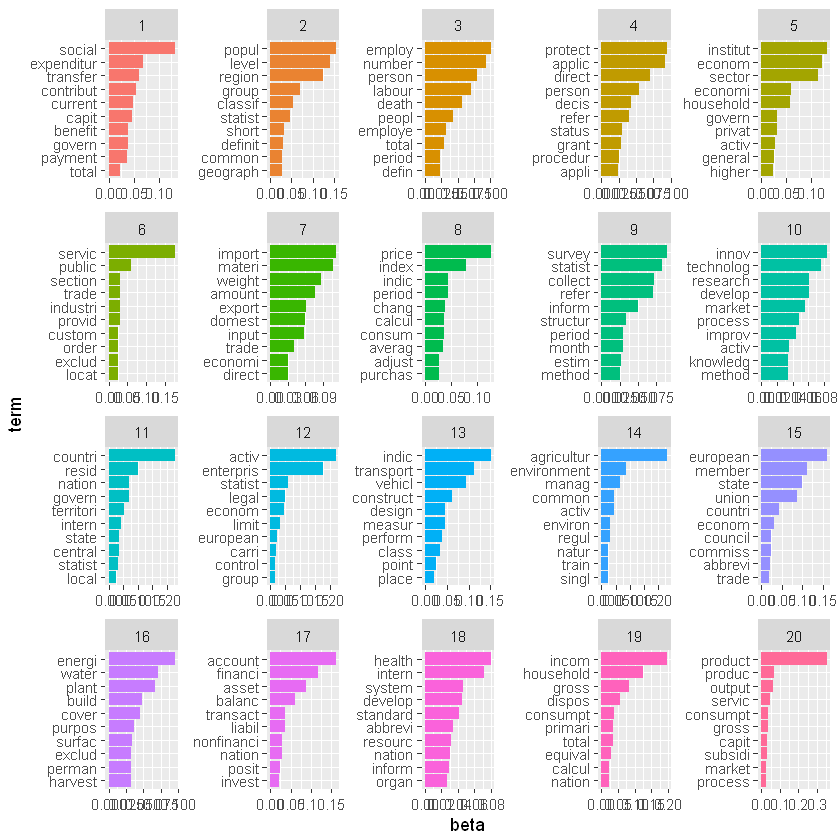

In [5]:
lda_model <- LDA(dtm, k = 20, control = list(seed = 1234))
topics <- tidy(lda_model, matrix = "beta")

top_terms <- topics %>%
  group_by(topic) %>%
  slice_max(beta, n = 10) %>% 
  ungroup() %>%
  arrange(topic, -beta)

top_terms %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(beta, term, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  scale_y_reordered()


The results with the top 10 terms by topic can be interpreted as follows: 

* Topic 1: Social expenditure and contributions.
* Topic 2: Population, regions and geography. 
* Topic 3: Persons and employment.
* Topic 4: Intellectual property rights. 
* Topic 5: Economic sectors.
* Topic 6: Public services.
* Topic 7: International trade.
* Topic 8: Price indices. 
* Topic 9: Surveys.
* Topic 10: Technology, research and innovation.
* Topic 11: Countries, territories and resident population.
* Topic 12: Business activities and enterprises.
* Topic 13: Transport. 
* Topic 14: Primary production and the environment.
* Topic 15: The EU and the member states.
* Topic 16: Energy and water resources.
* Topic 17: Accounting and finance.
* Topic 18: Healthcare.
* Topic 19: Households disposable income and consumption.
* Topic 20: Production, consumption and gross capital.

If these results are useful, the analysis will be extended to take into account the _gamma_ coefficients which express, for each document and topic, the **estimated proportion of terms from the document that are generated from that topic**.
